# 드라이브 연동 및 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ML_Project
!ls -al

/content/drive/MyDrive/ML_Project
total 2552132
-rw------- 1 root root   14931818 Nov 24 09:08 comp_sentences.csv
-rw------- 1 root root      22733 Dec  2 07:12 human_label.csv
-rw------- 1 root root        175 Dec  2 07:12 human_label.gsheet
drwx------ 2 root root       4096 Nov 24 07:52 TL_comp
-rw------- 1 root root 1229313082 Nov 24 05:58 TL.zip
-rw------- 1 root root 1073741824 Nov 22 16:34 TL.zip.part0
-rw------- 1 root root  155571258 Nov 22 16:36 TL.zip.part1
-rw------- 1 root root  139796319 Nov 22 16:37 VL.zip.part0


# 직접 라벨링할 샘플 만들기

In [3]:
"""
import pandas as pd

# 1) comp_sentences.csv 불러오기
df = pd.read_csv("comp_sentences.csv")

# 2) 데이터 크기 확인
print("전체 문장 수:", len(df))

# 3) 문자 형태로 casting
df["sentence"] = df["sentence"].astype(str)

# 4) 랜덤으로 200개 문장 샘플링
sample_df = df.sample(200, random_state=42).reset_index().rename(columns={"index": "sent_id"})

# 5) 라벨링할 컬럼은 아직 비워둠
sample_df = sample_df[["sent_id", "sentence"]]

# 6) CSV 저장
sample_df.to_csv("human_label.csv", index=False)

print("human_label.csv 생성 완료")
sample_df.head()
"""

print("이미 만들어 두었으므로 생략")

이미 만들어 두었으므로 생략


## 직접 라벨링 기준

### 핵심 문장(1)의 조건

- 강의 주요 개념을 직접 설명

- 정의, 원리, 공식을 언급

- 구조/관계/메커니즘 설명

- 주제 흐름에서 꼭 필요한 문장

### 비핵심 문장(0)의 조건

- 예시, 잡담, 진행 멘트, 반복 말투

- “됐나요?”, “그죠?”, “혹시 질문?”

- 특정 실습 안내

- 정보량이 부족하거나 단독으로 의미가 약함

In [4]:
import pandas as pd

human_df = pd.read_csv("human_label.csv")

print("human_label.csv 크기:", human_df.shape)
print("\n컬럼:")
print(human_df.columns)

print("\n앞부분 5개 행:")
display(human_df.head())

# 라벨 분포도 확인
print("\n라벨 분포(value_counts):")
print(human_df["label"].value_counts())

human_label.csv 크기: (200, 3)

컬럼:
Index(['sent_id', 'sentence', 'label'], dtype='object')

앞부분 5개 행:


,sent_id,sentence,label
0,11129,혹시 질문이 있으세요?,0
1,65730,그래서 어 리스트리드 (cascade)/(캐스케이드) 그다음에 기본 값으로 변경한 ...,1
2,65209,너무 (data)/(데이터)가 많으면 이 보여지는 화면이 좀 복잡하기 때문에 고객 ...,0
3,95416,글꼴은 굴림체 글자 크기는 11포인트 줄 간격은 18포인트 고정 어 내용 첫 줄은 ...,0
4,58033,그리고 그 문제에 피상적인 것을 해결하는 내용을 포함하여 근본적으로 이건 어떤 문제...,1



라벨 분포(value_counts):
label
0    133
1     67
Name: count, dtype: int64


# 전처리

## 중복 문장 제거

In [5]:
"""
import pandas as pd

df = pd.read_csv("comp_sentences.csv")

print("원본 데이터 크기:", df.shape)

# 중복 문장 수 확인
duplicate_count = df.duplicated(subset=["sentence"]).sum()
print("중복 문장 수:", duplicate_count)

# 중복 제거
df_dedup = df.drop_duplicates(subset=["sentence"]).reset_index(drop=True)

print("중복 제거 후 데이터 크기:", df_dedup.shape)

df_dedup.to_csv("comp_sentences_dedup.csv", index=False)
print("-> comp_sentences_dedup.csv 저장 완료")
"""
print("이미 만들어 두었으므로 생략")

원본 데이터 크기: (122144, 3)
중복 문장 수: 6254
중복 제거 후 데이터 크기: (115890, 3)
-> comp_sentences_dedup.csv 저장 완료


## stop words 및 cleaning

In [6]:
import pandas as pd
import re
from collections import Counter

df = pd.read_csv("comp_sentences_dedup.csv")

def simple_tokenize(text):
    return re.findall(r"[가-힣A-Za-z0-9]+", text)

all_tokens = []
for s in df["sentence"]:
    tokens = simple_tokenize(s)
    all_tokens.extend(tokens)

counter = Counter(all_tokens)

# 상위 300개 추출
top_300 = counter.most_common(300)

print("- TOP 300 TOKENS -")
for i, (tok, freq) in enumerate(top_300, start=1):
    print(f"{i:3}. {tok} ({freq})")

- TOP 300 TOKENS -
  1. 이 (19413)
  2. 그래서 (15032)
  3. 이제 (14205)
  4. 어 (13890)
  5. 자 (12788)
  6. 그 (12715)
  7. 이렇게 (12645)
  8. 우리가 (11399)
  9. 수 (10404)
 10. 이런 (10086)
 11. 있는 (9581)
 12. 뭐 (9293)
 13. 때 (5680)
 14. 하는 (5678)
 15. 지금 (5552)
 16. 그리고 (5439)
 17. 있습니다 (5386)
 18. 요 (5255)
 19. 그러면 (5146)
 20. 어떤 (4834)
 21. 게 (4734)
 22. 할 (4685)
 23. 좀 (4636)
 24. 한 (4605)
 25. 다 (4370)
 26. 거죠 (4321)
 27. 한번 (4219)
 28. 하고 (4212)
 29. 그다음에 (4209)
 30. 이게 (4005)
 31. 하면 (3921)
 32. 어떻게 (3894)
 33. 때문에 (3808)
 34. 거예요 (3770)
 35. 더 (3724)
 36. 를 (3659)
 37. 또 (3639)
 38. 여기 (3620)
 39. 거 (3604)
 40. 안 (3537)
 41. 아 (3492)
 42. 같은 (3482)
 43. 수가 (3398)
 44. 해서 (3358)
 45. 대한 (3301)
 46. 그런 (3219)
 47. 가 (3215)
 48. 됩니다 (3207)
 49. 되는 (3171)
 50. 것 (3092)
 51. 두 (3033)
 52. 겁니다 (2883)
 53. 많이 (2854)
 54. 데이터 (2761)
 55. 1 (2689)
 56. 있고 (2653)
 57. 있어요 (2641)
 58. 대해서 (2586)
 59. 내가 (2535)
 60. 다음에 (2502)
 61. 우리 (2483)
 62. 보면 (2461)
 63. 될 (2447)
 64. 가지고 (2442)
 65. 바로 (2368)
 

**Stopword로 넣은 것들**

- 강의 말버릇 / 필러

  예: “어, 자, 뭐, 요, 네, 음, 막, 그냥, 근데, 그죠, 거죠, 거예요, 거야, 되겠죠, 있겠죠…”

- 화자/청자 지시 (우리가 / 여러분 / 제가 / 저희가 등)

  → 거의 항상 메타 발화 (“우리가 한번 살펴보겠습니다”, “여러분 이거 보세요”)에 등장

- 공손/서술 끝맺음

  “합니다, 됩니다, 하겠습니다, 보겠습니다, 드릴, 할게요, 되고요…”

  → 문장 끝 장식일 뿐, 핵심 내용은 앞쪽에 있음

- 지시/대용어 (이거, 이건, 이거를, 이거는, 요거, 요게, 얘는, 그게, 그것도 등)

  → 문장 내 정보량 거의 없음 (무엇을 가리키는지는 전후 문맥, 핵심단어가 담당)

- 순수 문법 기능어 / 조사

  “이, 그, 를, 을, 은, 는, 의, 에, 에서, 로, 것, 것들, 거, 건, 거는, 거를 …”

In [8]:
"""
import pandas as pd
import re

df = pd.read_csv("comp_sentences_dedup.csv")
print("데이터:", df.shape)

# Stopword 리스트
stopwords = set([
    "이", "그래서", "이제", "어", "자", "그",
    "우리가", "이런", "뭐",
    "그리고", "있습니다", "요", "그러면", "게",
    "좀", "다", "거죠", "한번", "하고", "그다음에",
    "이게", "를", "또", "여기", "거", "아",
    "해서", "그런", "됩니다", "것", "겁니다",
    "있어요", "내가", "우리", "을", "그냥", "에",
    "근데", "걸", "있죠", "합니다", "여러분들이",
    "그러니까", "이거", "요렇게", "되겠죠", "돼요",
    "제가", "보시면", "되겠습니다", "네", "는", "예",
    "그런데", "것을", "의",
    "하겠습니다", "여러분들", "이걸", "것은", "건",
    "여러분", "그럼", "것들을", "얘는", "있고요",
    "거는", "우리는",
    "로", "일단", "것들이", "이건", "것이", "요런",
    "에서", "그니까", "있겠죠", "이거를", "거고",
    "뭐냐", "은",
    "드릴", "거야",
    "얘가", "그게", "것도",
    "요거", "쭉", "음", "그러면은", "딱", "저",
    "건데", "그걸", "되고요",
    "이것을", "사실은", "뭐가",
    "거고요", "하죠", "있잖아요", "할게요", "막",
    "그죠", "요거를",
    "저희가", "요게", "볼게요", "나", "보겠습니다",
    "이것도"
])

# 전처리, 전반적으로 클리닝
def preprocess(text):
    text = str(text).lower()                      # 소문자 변환
    text = re.sub(r"[^가-힣a-zA-Z0-9\s]", " ", text)  # 한글/영문/숫자 제외 모두 제거
    text = re.sub(r"\s+", " ", text).strip()      # 중복 공백 제거

    # 토큰화 (공백 기준)
    tokens = text.split()

    # Stopword 제거
    tokens = [t for t in tokens if t not in stopwords]

    # 다시 문장으로 합치기
    return " ".join(tokens)

# clean_sentence 생성
df["clean_sentence"] = df["sentence"].apply(preprocess)

df.to_csv("comp_sentences_clean.csv", index=False)
print("전처리 완료 -> comp_sentences_clean.csv 저장됨")

df[["sentence", "clean_sentence"]].head(10)
"""
print("이미 만들어 두었으므로 생략")

데이터: (115890, 3)
전처리 완료 -> comp_sentences_clean.csv 저장됨


,sentence,clean_sentence
0,자연 (log)/(로그)를 취한 겁니다.,자연 log 로그 취한
1,이렇게 하면 이렇게 된다.,이렇게 하면 이렇게 된다
2,1 0 1 1 0 이렇게 되니까 되니까 띠 모양 있는 부분만 남기고 다 죽이는 모든...,1 0 1 1 0 이렇게 되니까 되니까 띠 모양 있는 부분만 남기고 죽이는 모든 주...
3,통과시키는 걸 볼 수 있겠죠?,통과시키는 볼 수
4,이제 구성은 이렇게 되어 있고요.,구성은 이렇게 되어
5,왜냐하면 기존의 s라고 하는 값은 이제 이렇게 저희가 자연 (log)/(로그)를 취...,왜냐하면 기존의 s라고 하는 값은 이렇게 자연 log 로그 취한 거기 때문에 이렇게...
6,그래서 이렇게 되면 밴드 패스는 말 그대로 밴드 리젝트를 빼게 내주시면 됩니다.,이렇게 되면 밴드 패스는 말 그대로 밴드 리젝트를 빼게 내주시면
7,이렇게 s를 구하고 여기 네스포에스를 취하면 됩니다.,이렇게 s를 구하고 네스포에스를 취하면
8,얘는 요 까만색 부분을 이제 영어로 만드는 겁니다.,까만색 부분을 영어로 만드는
9,한번 (mopic)/(모픽) 필터를 준동형 필터라고 하는 걸 넣어서 넣어서 예선을 ...,mopic 모픽 필터를 준동형 필터라고 하는 넣어서 넣어서 예선을 하게 되는 절차는...


# Weak label 생성

In [9]:
import pandas as pd

# 전처리 완료된 데이터 불러오기
df = pd.read_csv("comp_sentences_clean.csv")

print("데이터 크기:", df.shape)
print(df.columns)

# 앞부분 몇 개 확인
df.head()

데이터 크기: (115890, 4)
Index(['lecture_id', 'major', 'sentence', 'clean_sentence'], dtype='object')


,lecture_id,major,sentence,clean_sentence
0,C02199,comp,자연 (log)/(로그)를 취한 겁니다.,자연 log 로그 취한
1,C02199,comp,이렇게 하면 이렇게 된다.,이렇게 하면 이렇게 된다
2,C02199,comp,1 0 1 1 0 이렇게 되니까 되니까 띠 모양 있는 부분만 남기고 다 죽이는 모든...,1 0 1 1 0 이렇게 되니까 되니까 띠 모양 있는 부분만 남기고 죽이는 모든 주...
3,C02199,comp,통과시키는 걸 볼 수 있겠죠?,통과시키는 볼 수
4,C02199,comp,이제 구성은 이렇게 되어 있고요.,구성은 이렇게 되어


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [11]:
def make_weak_labels_for_one_lecture(sub_df, top_ratio=0.15, min_top=3, max_top=10):
    """
    하나의 lecture_id에 해당하는 문장들에 대해
    TF-IDF + 코사인 유사도 기반 centrality 점수를 계산하고,
    상위 문장들을 weak_label=1로 지정.

    - top_ratio: 전체 문장 중 몇 %를 요약 문장으로 뽑을지 (예: 0.15 = 15%)
    - min_top: 최소 몇 개는 무조건 뽑을지
    - max_top: 너무 길어지는 것 방지용 상한
    """
    # clean 텍스트가 비어있으면 원문 sentence를 대신 사용
    texts = sub_df["clean_sentence"].fillna(sub_df["sentence"]).astype(str).tolist()

    # 문장 수
    n_sent = len(texts)

    # 기본: 전부 0으로 시작
    weak_labels = np.zeros(n_sent, dtype=int)

    # 문장이 너무 적으면(예: 2개 이하) 그냥 가장 앞 문장만 1로
    if n_sent <= 2:
        weak_labels[0] = 1
        return weak_labels

    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)

    # 문장 간 코사인 유사도
    sim_matrix = cosine_similarity(X)

    # "다른 문장들과의 평균 유사도"만 보도록 대각선 0으로
    np.fill_diagonal(sim_matrix, 0.0)

    # 각 문장의 centrality 점수 = 다른 문장들과의 평균 유사도
    scores = sim_matrix.mean(axis=1)

    # 몇 개 뽑을지 결정 (ratio + min/max 제한)
    k = int(n_sent * top_ratio)
    k = max(min_top, k)
    k = min(max_top, k)

    # 점수 기준 상위 k개 인덱스 선택
    top_indices = scores.argsort()[::-1][:k]

    weak_labels[top_indices] = 1
    return weak_labels

In [13]:
# 전체 데이터에 weak_label 컬럼 추가
df["weak_label"] = 0  # 기본값 0

# lecture_id 단위로 groupby
grouped = df.groupby("lecture_id")

total_lectures = len(grouped)
print("총 lecture_id 개수:", total_lectures)

processed = 0

for lecture_id, sub_df in grouped:
    idx = sub_df.index

    # 이 lecture에 대한 weak label 계산
    weak_labels = make_weak_labels_for_one_lecture(sub_df)

    df.loc[idx, "weak_label"] = weak_labels

    processed += 1
    if processed % 50 == 0:
        print(f"{processed}/{total_lectures} 개 강의 처리 완료")

# 분포 확인
print("\nweak_label 분포:")
print(df["weak_label"].value_counts())

# 저장
df.to_csv("comp_sentences_weaklabel.csv", index=False)
print("\ncomp_sentences_weaklabel.csv 저장 완료")

총 lecture_id 개수: 367
50/367 개 강의 처리 완료
100/367 개 강의 처리 완료
150/367 개 강의 처리 완료
200/367 개 강의 처리 완료
250/367 개 강의 처리 완료
300/367 개 강의 처리 완료
350/367 개 강의 처리 완료

weak_label 분포:
weak_label
0    112220
1      3670
Name: count, dtype: int64

comp_sentences_weaklabel.csv 저장 완료


# Train / Validation / Test Split

In [14]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("comp_sentences_weaklabel.csv")

print("전체 데이터:", df.shape)

# 1) Train(80%) / Temp(20%) 분리
train_df, temp_df = train_test_split(
    df,
    test_size=0.20,
    stratify=df["weak_label"],
    random_state=42
)

# 2) Temp(20%) → Validation(10%) / Test(10%) 분리
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["weak_label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Validation:", valid_df.shape)
print("Test:", test_df.shape)

# 파일 저장
train_df.to_csv("weak_train.csv", index=False)
valid_df.to_csv("weak_valid.csv", index=False)
test_df.to_csv("weak_test.csv", index=False)

print("\nCSV 저장 완료!")
print("weak_train.csv")
print("weak_valid.csv")
print("weak_test.csv")

전체 데이터: (115890, 5)
Train: (92712, 5)
Validation: (11589, 5)
Test: (11589, 5)

CSV 저장 완료!
weak_train.csv
weak_valid.csv
weak_test.csv


# TF-IDF 벡터화

In [15]:
import pandas as pd

train = pd.read_csv("weak_train.csv")
valid = pd.read_csv("weak_valid.csv")

print("train:", train.shape)
print("valid:", valid.shape)

# 입력, 라벨 분리
X_train = train["clean_sentence"].fillna("")
y_train = train["weak_label"]

X_valid = valid["clean_sentence"].fillna("")
y_valid = valid["weak_label"]

train: (92712, 5)
valid: (11589, 5)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=20000,    # 단어 2만개
    ngram_range=(1,2),     # unigram + bigram
    min_df=3               # 최소 3번 이상 등장하는 단어만 사용
)

tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)

X_train_tfidf.shape, X_valid_tfidf.shape

((92712, 20000), (11589, 20000))

# LogReg vs MLP

## LogReg

In [17]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=200,
    class_weight="balanced",   # Weak label은 0이 많아서 불균형 해결
    n_jobs=-1
)

logreg.fit(X_train_tfidf, y_train)

print("LogReg 학습 완료!")

LogReg 학습 완료!


In [35]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

valid_pred_logreg = logreg.predict(X_valid_tfidf)

# 결과를 변수로 저장, 나중에 비교용
acc_logreg = accuracy_score(y_valid, valid_pred_logreg)
f1_logreg = f1_score(y_valid, valid_pred_logreg, average="macro")

print("Accuracy:", acc_logreg)
print("Macro F1:", f1_logreg)
print("\nClassification Report:")
print(classification_report(y_valid, valid_pred_logreg))


Accuracy: 0.8905859004228147
Macro F1: 0.6109827698708137

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     11222
           1       0.18      0.68      0.28       367

    accuracy                           0.89     11589
   macro avg       0.58      0.79      0.61     11589
weighted avg       0.96      0.89      0.92     11589



In [36]:
import joblib

joblib.dump(logreg, "logreg_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("모델 및 벡터 저장 완료")

모델 및 벡터 저장 완료


## MLP

In [25]:
from sklearn.utils import resample
import pandas as pd

# weak_train.csv 다시 불러오기
train = pd.read_csv("weak_train.csv")

# 텍스트/라벨 분리
train_df = pd.DataFrame({
    "text": train["clean_sentence"].fillna(""),
    "label": train["weak_label"]
})

# 클래스별 분리
majority = train_df[train_df.label == 0]
minority = train_df[train_df.label == 1]

print("Before oversampling:", majority.shape, minority.shape)

# minority oversample -> majority와 다르게 적당히 늘리기(환경 고려)
minority_over = resample(
    minority,
    replace=True,
    n_samples=30000,
    random_state=42
)


# 합치고 섞기
train_balanced = pd.concat([majority, minority_over]).sample(frac=1, random_state=42)

print("After oversampling:", train_balanced.shape)

# oversampled 데이터로 새 train 준비
X_train_bal = train_balanced["text"]
y_train_bal = train_balanced["label"]

Before oversampling: (89776, 2) (2936, 2)
After oversampling: (119776, 2)


In [26]:
import joblib

# Logistic Regression 학습 때 저장해 둔 vectorizer 로드
tfidf = joblib.load("tfidf_vectorizer.pkl")

# Oversampled train 데이터 transform
X_train_bal_tfidf = tfidf.transform(X_train_bal)

# Validation transform도 다시 가져오기
valid = pd.read_csv("weak_valid.csv")
X_valid = valid["clean_sentence"].fillna("")
y_valid = valid["weak_label"]

X_valid_tfidf = tfidf.transform(X_valid)

X_train_bal_tfidf.shape, X_valid_tfidf.shape

((119776, 20000), (11589, 20000))

In [31]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation="relu",
    solver="adam",
    batch_size=1024,
    max_iter=10,
    early_stopping=True,
    random_state=42
)

mlp.fit(X_train_bal_tfidf, y_train_bal)

print("MLP 학습 완료!")

MLP 학습 완료!


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


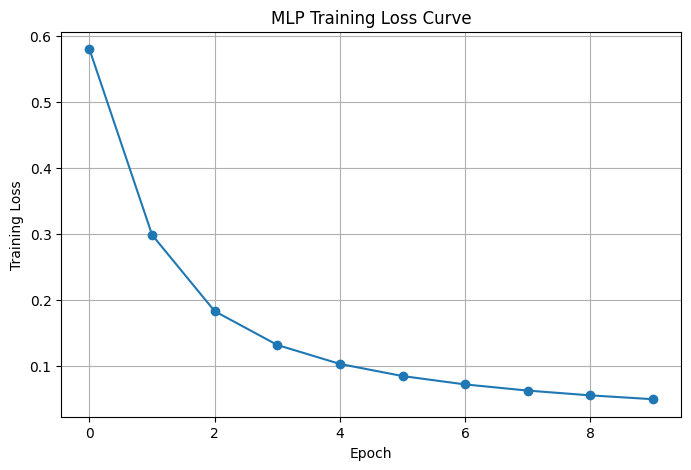

총 Epoch 수: 10


In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(mlp.loss_curve_, marker='o')
plt.title("MLP Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.show()

print(f"총 Epoch 수: {len(mlp.loss_curve_)}")

In [41]:
# early_stopping=True 이면, validation_score_ 속성이 존재함
try:
    print("Best Validation Score during Training:", mlp.best_validation_score_)
except:
    print("best_validation_score_를 제공하지 않는 버전입니다.")

# 최종 training loss도 함께 출력
print("Final Training Loss:", mlp.loss_curve_[-1])

Best Validation Score during Training: 0.9747036233094005
Final Training Loss: 0.04995970336050678


In [37]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

valid_pred_mlp = mlp.predict(X_valid_tfidf)

acc_mlp = accuracy_score(y_valid, valid_pred_mlp)
f1_mlp = f1_score(y_valid, valid_pred_mlp, average="macro")

print("Accuracy:", acc_mlp)
print("Macro F1:", f1_mlp)
print("\nClassification Report:")
print(classification_report(y_valid, valid_pred_mlp))

Accuracy: 0.9436534644921909
Macro F1: 0.618084927010307

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     11222
           1       0.23      0.32      0.27       367

    accuracy                           0.94     11589
   macro avg       0.60      0.64      0.62     11589
weighted avg       0.95      0.94      0.95     11589



In [38]:
import joblib

joblib.dump(mlp, "mlp_model.pkl")
print("MLP 모델 저장 완료")

MLP 모델 저장 완료


## 정리(서머리)

In [42]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Logistic Regression", "MLP Classifier"],
    "Accuracy": [acc_logreg, acc_mlp],
    "Macro F1": [f1_logreg, f1_mlp]
})

results

,Model,Accuracy,Macro F1
0,Logistic Regression,0.890586,0.610983
1,MLP Classifier,0.943653,0.618085


In [43]:
# 최종 선택된 모델
final_model = mlp
joblib.dump(final_model, "final_model.pkl")
print("final_model.pkl 저장 완료 – 최종 모델은 MLP Classifier")

final_model.pkl 저장 완료 – 최종 모델은 MLP Classifier
